In [1]:
import cv2
import numpy as np
import os
import pytesseract as pt
from sklearn import tree
import matplotlib.pyplot as plt

In [2]:
# settings
INPUT_WIDTH =  640
INPUT_HEIGHT = 640
imgRoiName = "./roi/roi123.jpg"

In [3]:
# LOAD YOLO MODEL
net = cv2.dnn.readNetFromONNX('./Model/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [4]:
def get_detections(img,net):
    # CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc, max_rc, 3), dtype = np.uint8)
    input_image[0 : row, 0 : col] = image

    # GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image, 1/255, (INPUT_WIDTH,INPUT_HEIGHT), swapRB = True, crop = False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

def non_maximum_supression(input_image,detections):
# FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE
# center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)
    # clean
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    # NMS
    index = np.array(cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)).flatten()
    return boxes_np, confidences_np, index

def drawings(image,boxes_np,confidences_np,index):
# drawings
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])

        roi = image[y:y+h, x:x+w]
        # cv2.imwrite(imgRoiName, roi)
    
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+30),(0,0,0),-1)
        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),1)
        cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1)
    return image

In [5]:
# predictions
def yolo_predictions(img,net):
    # step-1: detections
    input_image, detections = get_detections(img,net)
    # step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    # step-3: Drawings
    result_img = drawings(img,boxes_np,confidences_np,index)

    return result_img

In [6]:
def extract_text(image,bbox):
    x, y, w, h = bbox
    roi = image[y:y+h, x:x+w]
    
    if 0 in roi.shape:
        return ''
    
    else:
        text = pt.image_to_string(roi)
        text = text.strip()
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        cv2.imwrite(imgRoiName, roi)
        
        return text

### Real Time Object Detection

QObject::moveToThread: Current thread (0x61bdda0) is not the object's thread (0x4a46b20).
Cannot move to target thread (0x61bdda0)

QObject::moveToThread: Current thread (0x61bdda0) is not the object's thread (0x4a46b20).
Cannot move to target thread (0x61bdda0)

QObject::moveToThread: Current thread (0x61bdda0) is not the object's thread (0x4a46b20).
Cannot move to target thread (0x61bdda0)

QObject::moveToThread: Current thread (0x61bdda0) is not the object's thread (0x4a46b20).
Cannot move to target thread (0x61bdda0)

QObject::moveToThread: Current thread (0x61bdda0) is not the object's thread (0x4a46b20).
Cannot move to target thread (0x61bdda0)

QObject::moveToThread: Current thread (0x61bdda0) is not the object's thread (0x4a46b20).
Cannot move to target thread (0x61bdda0)

QObject::moveToThread: Current thread (0x61bdda0) is not the object's thread (0x4a46b20).
Cannot move to target thread (0x61bdda0)

QObject::moveToThread: Current thread (0x61bdda0) is not the object's thread

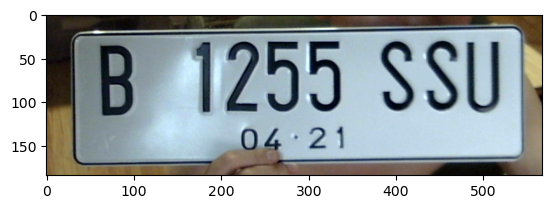

In [7]:
# cap = cv2.VideoCapture('./test_images/traffic.mp4')
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    
    if ret == False:
        print('unable to read video')
        break
        
    results = yolo_predictions(frame,net)
    
    cv2.namedWindow('YOLO',cv2.WINDOW_KEEPRATIO)
    cv2.imshow('YOLO',results)
    if cv2.waitKey(1) == 27:
        break
        
cv2.destroyAllWindows()
cap.release()

In [8]:
import cv2
import numpy as np
from imutils.object_detection import non_max_suppression

img = imgRoiName

## -------------  Load the pre-trained models ---------------
model = cv2.dnn.readNet('./frozen_east_text_detection.pb')
model1 = cv2.dnn.readNet('./crnn.onnx')

## -------------  Prepare the image  ----------------
# use multiple of 32 to set the new img shape
height, width, _ = img.shape
new_height = (height//32)*32
new_width = (width//32)*32

# get the ratio change in width and height
h_ratio = height/new_height
w_ratio = width/new_width

blob = cv2.dnn.blobFromImage(img, 1, (new_width, new_height),(123.68, 116.78, 103.94), True, False)

## -------------  Forward Propagation  -------------
model.setInput(blob)
(geometry, scores) = model.forward(model.getUnconnectedOutLayersNames())


## -------------   Post-Processing  ----------------
rectangles = []
confidence_score = []
for i in range(geometry.shape[2]):
    for j in range(0, geometry.shape[3]):
        
        if scores[0][0][i][j] < 0.1:
            continue
            
        bottom_x = int(j*4 + geometry[0][1][i][j])
        bottom_y = int(i*4 + geometry[0][2][i][j])
        

        top_x = int(j*4 - geometry[0][3][i][j])
        top_y = int(i*4 - geometry[0][0][i][j])
        
        rectangles.append((top_x, top_y, bottom_x, bottom_y))
        confidence_score.append(float(scores[0][0][i][j]))
		
		
# use Non-max suppression to get the required rectangles
fin_boxes = non_max_suppression(np.array(rectangles), probs=confidence_score, overlapThresh=0.5)


## --------------- Load the CRNN decoding functions -------------
def most_likely(scores, char_set):
    text = ""
    for i in range(scores.shape[0]):
        c = np.argmax(scores[i][0])
        text += char_set[c]
    return text

def map_rule(text):
    char_list = []
    for i in range(len(text)):
        if i == 0:
            if text[i] != '-':
                char_list.append(text[i])
        else:
            if text[i] != '-' and (not (text[i] == text[i - 1])):
                char_list.append(text[i])
    return ''.join(char_list)

def best_path(scores, char_set):
    text = most_likely(scores, char_set)
    final_text = map_rule(text)
    return final_text
	

alphabet_set = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
blank = '-'

char_set = blank + alphabet_set

## ---------------  Recognize the text using CRNN in each segment -----------
img_copy = img.copy()
for (x1, y1, x2, y2) in fin_boxes:

    x1 = int(x1 * w_ratio)
    y1 = int(y1 * h_ratio)
    x2 = int(x2 * w_ratio)
    y2 = int(y2 * h_ratio)
    
    segment = img[y1:y2, x1:x2, :]
    
    segment_gray = cv2.cvtColor(segment, cv2.COLOR_BGR2GRAY)
    blob = cv2.dnn.blobFromImage(segment_gray, scalefactor=1/127.5, size=(100,32), mean=127.5)
    
    model1.setInput(blob)
    scores = model1.forward()
    text = best_path(scores, char_set)

    cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_copy, text.strip().upper(), (x1,y1-2), cv2.FONT_HERSHEY_COMPLEX, 0.7, (0,0,255),2)
    print(text.strip().upper())

plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))

AttributeError: 'str' object has no attribute 'shape'

In [ ]:
import cv2
import pytesseract
import numpy as np
from imutils.object_detection import non_max_suppression


img = "./test_images/17.jpg"

## -------------  Load the pre-trained models ---------------
model = cv2.dnn.readNet('./frozen_east_text_detection.pb')

## -------------  Prepare the image  ----------------
# use multiple of 32 to set the new img shape
height, width, _ = img.shape
new_height = (height//32)*32
new_width = (width//32)*32
print(new_height, new_width)

# get the ratio change in width and height
h_ratio = height/new_height
w_ratio = width/new_width
print(h_ratio, w_ratio)

blob = cv2.dnn.blobFromImage(img, 1, (new_width, new_height),(123.68, 116.78, 103.94), True, False)

## -------------  Forward Propagation  -------------
model.setInput(blob)
(geometry, scores) = model.forward(model.getUnconnectedOutLayersNames())


## -------------   Post-Processing  ----------------
rectangles = []
confidence_score = []
for i in range(geometry.shape[2]):
    for j in range(0, geometry.shape[3]):
        
        if scores[0][0][i][j] < 0.1:
            continue
            
        bottom_x = int(j*4 + geometry[0][1][i][j])
        bottom_y = int(i*4 + geometry[0][2][i][j])
        

        top_x = int(j*4 - geometry[0][3][i][j])
        top_y = int(i*4 - geometry[0][0][i][j])
        
        rectangles.append((top_x, top_y, bottom_x, bottom_y))
        confidence_score.append(float(scores[0][0][i][j]))
		
		
# use Non-max suppression to get the required rectangles
fin_boxes = non_max_suppression(np.array(rectangles), probs=confidence_score, overlapThresh=0.5)

## ---------------  Recognize the text using Pytesseract in each segment -----------
img_copy = img.copy()
for (x1, y1, x2, y2) in fin_boxes:

    x1 = int(x1 * w_ratio)
    y1 = int(y1 * h_ratio)
    x2 = int(x2 * w_ratio)
    y2 = int(y2 * h_ratio)
    
    segment = img[y1:y2+4, x1:x2+2, :]
    
    segment_gray = cv2.cvtColor(segment, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(segment_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    text = pytesseract.image_to_string(thresh, config=r"--psm 8")

    cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_copy, text.strip(), (x1,y1-2), cv2.FONT_HERSHEY_COMPLEX, 0.7, (0,0,255),2)
    print(text.strip().upper())
    
plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))

AttributeError: 'str' object has no attribute 'shape'

In [ ]:
import cv2
import numpy as np
from imutils.object_detection import non_max_suppression


## -----------   Load Pre-trained Models ------------
model = cv2.dnn.readNet('./frozen_east_text_detection.pb')
model1 = cv2.dnn.readNet('./crnn.onnx')

def most_likely(scores, char_set):
    text = ""
    for i in range(scores.shape[0]):
        c = np.argmax(scores[i][0])
        text += char_set[c]
    return text

def map_rule(text):
    char_list = []
    for i in range(len(text)):
        if i == 0:
            if text[i] != '-':
                char_list.append(text[i])
        else:
            if text[i] != '-' and (not (text[i] == text[i - 1])):
                char_list.append(text[i])
    return ''.join(char_list)

def best_path(scores, char_set):
    text = most_likely(scores, char_set)
    final_text = map_rule(text)
    return final_text
	
alphabet_set = "0123456789abcdefghijklmnopqrstuvwxyz"
blank = '-'

char_set = blank + alphabet_set


## ----------  Performing OCR in live video ----------
cap = cv2.VideoCapture(0)

while cap.isOpened():

    ret, img = cap.read()
    # use multiple of 32 to set the new img shape
    height, width, _ = img.shape
    new_height = (height//32)*32
    new_width = (width//32)*32

    # get the ratio change in width and height
    h_ratio = height/new_height
    w_ratio = width/new_width

    blob = cv2.dnn.blobFromImage(img,1.0, (new_width, new_height), (123.68, 116.78, 103.94), True, False)

    model.setInput(blob)
    (geometry, scores) = model.forward(model.getUnconnectedOutLayersNames())

    rectangles = []
    confidence_score = []
    for i in range(geometry.shape[2]):
        for j in range(0, geometry.shape[3]):

            if scores[0][0][i][j] < 0.1:
                continue

            bottom_x = int(j*4 + geometry[0][1][i][j])
            bottom_y = int(i*4 + geometry[0][2][i][j])


            top_x = int(j*4 - geometry[0][3][i][j])
            top_y = int(i*4 - geometry[0][0][i][j])

            rectangles.append((top_x, top_y, bottom_x, bottom_y))
            confidence_score.append(float(scores[0][0][i][j]))

    # use Non-max suppression to get the required rectangles
    fin_boxes = non_max_suppression(np.array(rectangles), probs=confidence_score, overlapThresh=0.5)

    img_copy = img.copy()
    for (x1, y1, x2, y2) in fin_boxes:

        x1 = int(x1 * w_ratio)
        y1 = int(y1 * h_ratio)
        x2 = int(x2 * w_ratio)
        y2 = int(y2 * h_ratio)

        segment = img[y1:y2+4, x1:x2+2, :]
        segment_gray = cv2.cvtColor(segment, cv2.COLOR_BGR2GRAY)
        
        blob = cv2.dnn.blobFromImage(segment_gray, scalefactor=1/127.5, size=(100,32), mean=127.5)
        model1.setInput(blob)
        scores = model1.forward()
        text = best_path(scores, char_set)

        cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_copy, text.strip().upper(), (x1,y1-2), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0,0,255),2)

    cv2.imshow("Text Detection", img_copy)
    if cv2.waitKey(1) == 113:
        break

cap.release()
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x10382a00) is not the object's thread (0x3267e40).
Cannot move to target thread (0x10382a00)

QObject::moveToThread: Current thread (0x10382a00) is not the object's thread (0x3267e40).
Cannot move to target thread (0x10382a00)

QObject::moveToThread: Current thread (0x10382a00) is not the object's thread (0x3267e40).
Cannot move to target thread (0x10382a00)

QObject::moveToThread: Current thread (0x10382a00) is not the object's thread (0x3267e40).
Cannot move to target thread (0x10382a00)

QObject::moveToThread: Current thread (0x10382a00) is not the object's thread (0x3267e40).
Cannot move to target thread (0x10382a00)

QObject::moveToThread: Current thread (0x10382a00) is not the object's thread (0x3267e40).
Cannot move to target thread (0x10382a00)

QObject::moveToThread: Current thread (0x10382a00) is not the object's thread (0x3267e40).
Cannot move to target thread (0x10382a00)

QObject::moveToThread: Current thread (0x10382a00) is not the 